In [1]:
%matplotlib inline
# data manipulation libraries
import pandas as pd
import numpy as np

from time import time

# Graphs libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly import tools

# Libraries to study
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import LFR, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification

# ML libraries
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

# Design libraries
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings("ignore")
from aif360.datasets import MEPSDataset19


C:\Users\srinivas\AppData\Local\Temp\ipykernel_36416\1330569207.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


c:\Users\srinivas\anaconda3\Lib\site-packages\torch\_functorch\deprecated.py:61: UserWarning:

We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html



In [2]:
dataset_orig_panel19_train,dataset_orig_panel19_test = MEPSDataset19().split([0.7], shuffle=True)

In [3]:
sens_ind = 0
sens_attr = dataset_orig_panel19_train.protected_attribute_names[sens_ind]
unprivileged_groups = [{sens_attr: v} for v in
                    dataset_orig_panel19_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                    dataset_orig_panel19_train.privileged_protected_attributes[sens_ind]]

In [5]:
data_orig_test_pred = dataset_orig_panel19_test.copy(deepcopy=True)
# Prediction with the original RandomForest model
scores = np.zeros_like(dataset_orig_panel19_test.labels)


In [6]:
features = dataset_orig_panel19_train.features
label = dataset_orig_panel19_train.labels
feature_names = dataset_orig_panel19_train.feature_names
dataset_orig_panel19_train_df = pd.DataFrame(features, columns=feature_names)
dataset_orig_panel19_train_df['label'] = label
dataset_orig_panel19_train_df

,AGE,RACE,PCS42,MCS42,K6SUM42,REGION=1,REGION=2,REGION=3,REGION=4,SEX=1,...,EMPST=4,POVCAT=1,POVCAT=2,POVCAT=3,POVCAT=4,POVCAT=5,INSCOV=1,INSCOV=2,INSCOV=3,label
0,9.0,0.0,-1.00,-1.00,-1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,85.0,0.0,27.95,48.73,5.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,7.0,0.0,-1.00,-1.00,-1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,54.0,0.0,54.88,57.41,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,65.0,0.0,40.02,45.85,5.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11076,24.0,1.0,60.47,50.65,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
11077,11.0,0.0,-1.00,-1.00,-1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
11078,23.0,0.0,57.84,54.35,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
11079,71.0,0.0,-1.00,-1.00,-1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


Training Accuracy: 0.8621389891696751, Training Log Loss: 0.3308866299546088
Testing Accuracy: 0.8633288227334236, Testing Log Loss: 0.3319915144634525


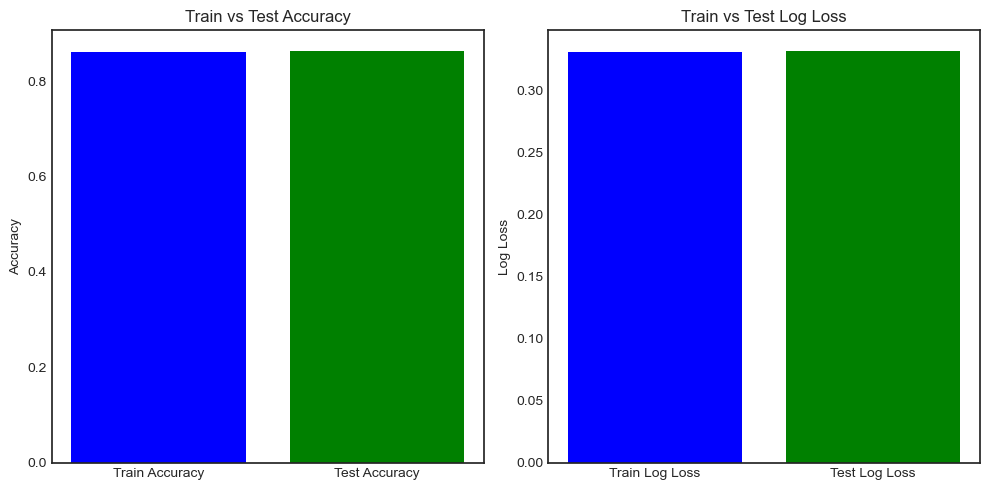

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

# Assuming 'df' is your Pandas DataFrame with features, 'label', and 'weights' columns
df=dataset_orig_panel19_train_df
# Split the DataFrame into features, labels, and weights

X = df.drop(['label'], axis=1)
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = LogisticRegression()

# Train the model using the sample_weight parameter
# We need to extract the corresponding weights for the training samples
train_indices = X_train.index

model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Probability predictions for log loss calculation
y_train_pred_proba = model.predict_proba(X_train)
y_test_pred_proba = model.predict_proba(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calculate log loss
train_loss = log_loss(y_train, y_train_pred_proba)
test_loss = log_loss(y_test, y_test_pred_proba)

# Print errors and losses
print(f"Training Accuracy: {train_accuracy}, Training Log Loss: {train_loss}")
print(f"Testing Accuracy: {test_accuracy}, Testing Log Loss: {test_loss}")

# Plotting
plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_accuracy, test_accuracy], color=['blue', 'green'])
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')

# Log Loss plot
plt.subplot(1, 2, 2)
plt.bar(['Train Log Loss', 'Test Log Loss'], [train_loss, test_loss], color=['blue', 'green'])
plt.ylabel('Log Loss')
plt.title('Train vs Test Log Loss')

plt.tight_layout()
plt.show()


In [9]:
scores = model.predict_proba(dataset_orig_panel19_test.features)[:,1].reshape(-1,1)
data_orig_test_pred.scores = scores

preds = np.zeros_like(dataset_orig_panel19_test.labels)

In [10]:
preds = model.predict(dataset_orig_panel19_test.features).reshape(-1,1)
data_orig_test_pred.labels = preds

def format_probs(probs1):
    probs1 = np.array(probs1)
    probs0 = np.array(1-probs1)
    return np.concatenate((probs0, probs1), axis=1)

In [16]:
cost_constraint = "fnr" # "fnr", "fpr", "weighted"

CPP = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=42)

CPP = CPP.fit(dataset_orig_panel19_test, data_orig_test_pred)
data_transf_test_pred = CPP.predict(data_orig_test_pred)

In [17]:
data_transf_test_pred

               instance weights features                                    \
                                         protected attribute                 
                                     AGE                RACE  PCS42  MCS42   
instance names                                                               
13357               9766.309748     47.0                 1.0  44.67  58.50   
1622                3687.136625     15.0                 0.0  -1.00  -1.00   
10655               3162.965899     35.0                 0.0  48.79  46.12   
13275                  0.000000      2.0                 0.0  -1.00  -1.00   
16189              10437.058559     39.0                 0.0  53.71  53.48   
...                         ...      ...                 ...    ...    ...   
3594                3137.852722      8.0                 0.0  -1.00  -1.00   
6600               12813.157945      5.0                 0.0  -1.00  -1.00   
5029                8074.453027     36.0                 0.0  50

In [19]:
from aif360.metrics import BinaryLabelDatasetMetric

# Explainers
from aif360.explainers import MetricTextExplainer

In [21]:
metric_transf_panel19_test = BinaryLabelDatasetMetric(
data_transf_test_pred,
unprivileged_groups=unprivileged_groups,
privileged_groups=privileged_groups)
explainer_transf_panel19_cpp = MetricTextExplainer(metric_transf_panel19_test)
test_results_cpp=[explainer_transf_panel19_cpp.mean_difference()
               ,explainer_transf_panel19_cpp.consistency()
               ,explainer_transf_panel19_cpp.statistical_parity_difference()
               ,explainer_transf_panel19_cpp.disparate_impact()]

In [22]:
test_results_cpp

['Mean difference (mean label value on unprivileged instances - mean label value on privileged instances): 0.011554085192856722',
 'Consistency (Zemel, et al. 2013): [0.9505159]',
 'Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): 0.011554085192856722',
 'Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.29280637210065']

In [24]:
ROC = RejectOptionClassification(privileged_groups = privileged_groups,
                             unprivileged_groups = unprivileged_groups)

ROC = ROC.fit(dataset_orig_panel19_test, data_orig_test_pred)
data_transf_test_pred_roc = ROC.predict(data_orig_test_pred)

In [27]:
metric_transf_panel19_test = BinaryLabelDatasetMetric(
data_transf_test_pred_roc,
unprivileged_groups=unprivileged_groups,
privileged_groups=privileged_groups)
explainer_transf_panel19_roc = MetricTextExplainer(metric_transf_panel19_test)
test_results_roc=[explainer_transf_panel19_roc.mean_difference()
               ,explainer_transf_panel19_roc.consistency()
               ,explainer_transf_panel19_roc.statistical_parity_difference()
               ,explainer_transf_panel19_roc.disparate_impact()]

In [28]:
test_results_roc

['Mean difference (mean label value on unprivileged instances - mean label value on privileged instances): -0.040726123105935985',
 'Consistency (Zemel, et al. 2013): [0.85171615]',
 'Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): -0.040726123105935985',
 'Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.8861379636018648']